In [1]:
import argparse
import os
import torch
import pyro
import json
import math
from tqdm import tqdm
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import PyroOptim
from pyro.optim import Adam
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree
import seaborn as sns

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import lightning as L
import torch.nn.functional as F
from torch.utils.data import DataLoader

import subprocess
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import GPUtil

In [2]:
if torch.cuda.is_available():
    print("YAY! GPU available :3")
    
    # Get all available GPUs sorted by memory usage (lowest first)
    available_gpus = GPUtil.getAvailable(order='memory', limit=1)
    
    if available_gpus:
        selected_gpu = available_gpus[0]
        
        # Set the GPU with the lowest memory usage
        torch.cuda.set_device(selected_gpu)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        
        print(f"Using GPU: {selected_gpu} with the lowest memory usage.")
    else:
        print("No GPUs available with low memory usage.")
else:
    print("No GPU available :(")

YAY! GPU available :3
Using GPU: 0 with the lowest memory usage.


In [3]:
def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    clustering.pca(clustering.xenium_spot_data, num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]

    return data, spatial_locations, clustering

def prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=100, 
        third_dim=False, 
        log_normalize=True,
        likelihood_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
        min_expressions_per_spot=10
    ):

    data_filepath = f"data/spot_data/{dataset}/hBreast_SPOTSIZE={spot_size}um_z={third_dim}.h5ad"
    
    if spots:

        if os.path.exists(data_filepath):

            clustering = XeniumCluster(data=None, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)
            print("Loading data.")
            clustering.xenium_spot_data = ad.read_h5ad(data_filepath)

        else:

            # Path to your .gz file
            file_path = f'data/{dataset}/transcripts.csv.gz'

            # Read the gzipped CSV file into a DataFrame
            df_transcripts = pd.read_csv(file_path, compression='gzip')
            df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
            df_transcripts.head(), df_transcripts.shape

            # drop cells without ids
            df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

            # drop blanks and controls
            df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

            clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)

            if not os.path.exists(data_filepath):
                print("Generating and saving data")
                clustering.create_spot_data(third_dim=third_dim, save_data=True)
                clustering.xenium_spot_data.write_h5ad(data_filepath)

        print("Number of spots: ", clustering.xenium_spot_data.shape[0])
        clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
        print("Number of spots after filtering: ", clustering.xenium_spot_data.shape[0])

        if log_normalize:
            clustering.normalize_counts(clustering.xenium_spot_data)

        if likelihood_mode == "PCA":
            clustering.pca(clustering.xenium_spot_data, num_pcs)
            data = clustering.xenium_spot_data.obsm["X_pca"]
        elif likelihood_mode == "HVG":
            min_dispersion = torch.distributions.normal.Normal(0.0, 1.0).icdf(hvg_var_prop)
            clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=min_dispersion)
            clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
            data = clustering.xenium_spot_data.X
        elif likelihood_mode == "ALL":
            data = clustering.xenium_spot_data.X

        spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
    
    # prepare cells data
    else:

        cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
        cells_pivot = cells.pivot_table(index='cell_id', 
                                        columns='feature_name', 
                                        values='count', 
                                        fill_value=0)
        
        location_means = df_transcripts.groupby('cell_id').agg({
            'x_location': 'mean',
            'y_location': 'mean',
            'z_location': 'mean'
        }).reset_index()

        cells_pivot = location_means.join(cells_pivot, on='cell_id')

        if log_normalize:
            # log normalization
            cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

        if likelihood_mode == "PCA":
            pca = PCA(n_components=num_pcs)
            data = pca.fit_transform(cells_pivot.iloc[:, 4:])

        elif likelihood_mode == "HVG":
            genes = cells_pivot.iloc[:, 4:]
            gene_variances = genes.var(axis=0)
            gene_variances = gene_variances.sort_values(ascending=False)
            gene_var_proportions = (gene_variances / sum(gene_variances))
            relevant_genes = list(gene_var_proportions[(gene_var_proportions.cumsum() < hvg_var_prop)].index)
            cells_pivot.iloc[:, 4:] = cells_pivot.iloc[:, 4:][[relevant_genes]]
            data = cells_pivot.iloc[:, 4:]

        elif likelihood_mode == "ALL":
            data = cells_pivot.iloc[:, 4:]

        spatial_locations = cells_pivot[["x_location", "y_location"]]

    # the last one is to regain var/obs access from original data
    return data, spatial_locations, clustering 

In [4]:
spot_size=50
data_mode="PCA"
num_pcs=10
hvg_var_prop=0.9
dataset_name="hBreast"
kmeans_init=True
custom_init="K-Means"
spatial_init=True
num_clusters=7
batch_size=512
neighborhood_size=1
neighborhood_agg="mean"
concentration_amplification=10.0
# uncertainty_values = [1/num_clusters, 2/num_clusters, 3/num_clusters, 4/num_clusters, 5/num_clusters]
uncertainty_values = [0.25, 0.5, 0.75, 0.9, 0.99]
evaluate_markers=False
spatial_normalize=0.00

In [5]:
gene_data, spatial_locations, original_adata = prepare_Xenium_data(
    dataset="hBreast", 
    spots=True, 
    spot_size=spot_size, 
    third_dim=False, 
    log_normalize=True, 
    likelihood_mode=data_mode, 
    num_pcs=num_pcs,
    hvg_var_prop=hvg_var_prop,
    min_expressions_per_spot=0
)

Loading data.
Number of spots:  23444
Number of spots after filtering:  23444


In [6]:
def save_filepath(model, component, sample_for_assignment=None):

    total_file_path = (
        f"results/{dataset_name}/{model}/{component}/{data_file_path}/"
        f"INIT={custom_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={num_clusters}"
        f"/SPATIALINIT={spatial_init}/SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"/SPATIALNORM={spatial_normalize}/SPATIALPRIORMULT={concentration_amplification}/SPOTSIZE={spot_size}/AGG={neighborhood_agg}"
    )

    return total_file_path

In [7]:
def custom_cluster_initialization(original_adata, method, K=17):

    original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, plot_pcas=False)

    # This function initializes clusters based on the specified method
    if method == "K-Means":
        initial_clusters = original_adata.KMeans(original_adata.xenium_spot_data, save_plot=False, K=K, include_spatial=False)
    elif method == "Hierarchical":
        initial_clusters = original_adata.Hierarchical(original_adata.xenium_spot_data, save_plot=True, num_clusters=K)
    elif method == "Leiden":
        initial_clusters = original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.75], save_plot=False, K=K)[0.75]
    elif method == "Louvain":
        initial_clusters = original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[1.0], save_plot=False, K=K)[1.0]
    elif method == "mclust":
        original_adata.pca(original_adata.xenium_spot_data, num_pcs)
        initial_clusters = original_adata.mclust(original_adata.xenium_spot_data, G_min=K, G_max=K, model_name = "EEE")
    else:
        raise ValueError(f"Unknown method: {method}")

    return initial_clusters

100%|██████████| 23444/23444 [00:02<00:00, 9300.13it/s]


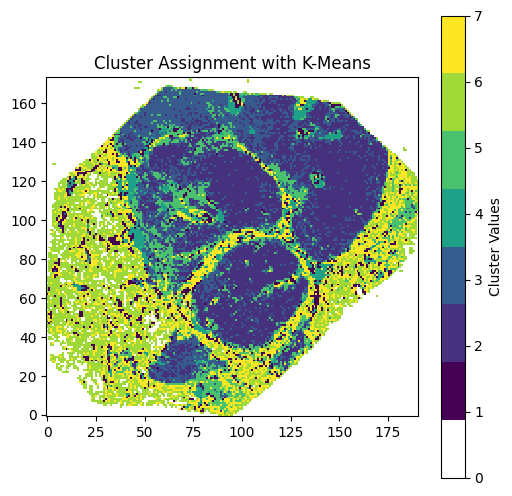

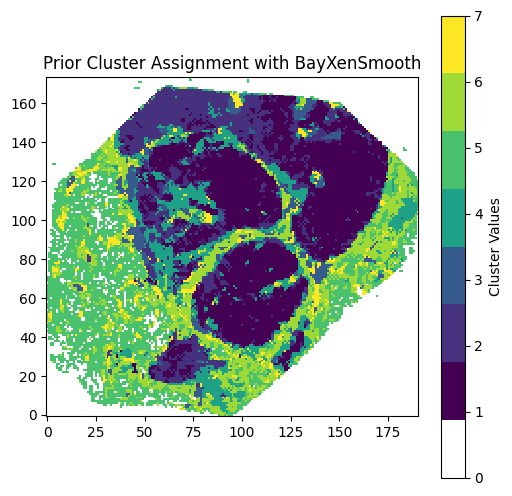

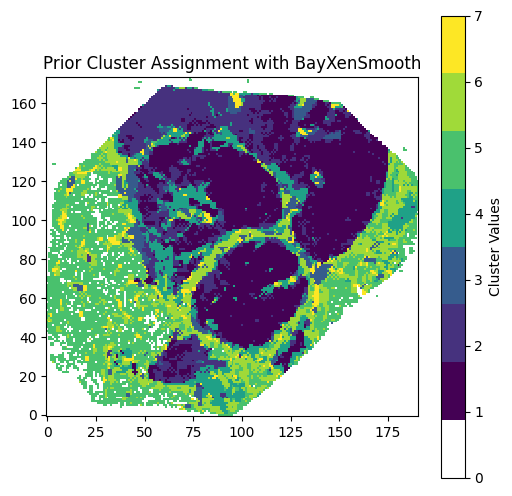

In [8]:
# Clamping
MIN_CONCENTRATION = 0.01

num_posterior_samples = 100

spatial_init_data = StandardScaler().fit_transform(gene_data)
gene_data = StandardScaler().fit_transform(gene_data)
empirical_prior_means = torch.zeros(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

if custom_init or kmeans_init:

    if custom_init:

        initial_clusters = custom_cluster_initialization(original_adata, custom_init, K=num_clusters)

    elif kmeans_init:

        kmeans_init_data = np.concatenate((spatial_locations, original_adata.xenium_spot_data.X), axis=1)
        kmeans_init_data = StandardScaler().fit_transform(kmeans_init_data)

        if spatial_normalize:

            spatial_dim = spatial_locations.shape[1]
            gene_dim = original_adata.xenium_spot_data.X.shape[1]
            spatial_factor = (gene_dim * spatial_normalize / (spatial_dim * (1 - spatial_normalize))) ** 0.5
            kmeans_init_data[:, :spatial_locations.shape[1]] *= spatial_factor

        kmeans = KMeans(n_clusters=num_clusters).fit(kmeans_init_data)

        initial_clusters = kmeans.predict(kmeans_init_data)

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")
        
    if kmeans_init and not custom_init:

        if not os.path.exists(kmeans_clusters_filepath := save_filepath("KMeans", "clusters")):
            os.makedirs(kmeans_clusters_filepath)
        _ = plt.savefig(
            f"{kmeans_clusters_filepath}/result.png"
        )

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)
        
        cluster_grid[rows, columns] = torch.tensor(initial_clusters, dtype=torch.int) + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Cluster Assignment with KMeans')

    if dataset_name == "DLPFC":
        # Create a DataFrame for easier handling
        data = pd.DataFrame({
            'ClusterAssignments': initial_clusters,
            'Region': original_adata.xenium_spot_data.obs["Region"]
        })

        # Drop rows where 'Region' is NaN
        filtered_data = data.dropna(subset=['Region'])

        # Calculate ARI and NMI only for the non-NaN entries
        ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        cluster_metrics = {
            "ARI": ari,
            "NMI": nmi
        }

        data_file_path = f"{data_mode}/{num_pcs}"

        if not os.path.exists(kmeans_cluster_metrics_filepath := save_filepath("KMeans", "cluster_metrics")):
            os.makedirs(kmeans_cluster_metrics_filepath)
        with open(f"{kmeans_cluster_metrics_filepath}/wss.json", 'w') as fp:
            json.dump(cluster_metrics, fp)

    for i in range(num_clusters):
        cluster_data = gene_data[initial_clusters == i]
        if cluster_data.size > 0:  # Check if there are any elements in the cluster_data
            empirical_prior_means[i] = torch.tensor(cluster_data.mean(axis=0))
            empirical_prior_scales[i] = torch.tensor(cluster_data.std(axis=0))
    cluster_probs_prior = torch.zeros((initial_clusters.shape[0], num_clusters))
    cluster_probs_prior[torch.arange(initial_clusters.shape[0]), initial_clusters - 1] = 1.

else:

    cluster_probs_prior = torch.ones((len(gene_data), num_clusters), dtype=float)

locations_tensor = torch.tensor(spatial_locations.to_numpy())

# Compute the number of elements in each dimension
num_spots = cluster_probs_prior.shape[0]

# Initialize an empty tensor for spatial concentration priors
spatial_cluster_probs_prior = torch.zeros_like(cluster_probs_prior, dtype=torch.float64)

spot_locations = KDTree(locations_tensor.cpu())  # Ensure this tensor is in host memory
neighboring_spot_indexes = spot_locations.query_ball_point(locations_tensor.cpu(), r=neighborhood_size, p=1, workers=8)

# Iterate over each spot
for i in tqdm(range(num_spots)):

    # Select priors in the neighborhood
    priors_in_neighborhood = cluster_probs_prior[neighboring_spot_indexes[i]]
    # print(f"Spot {i} has {len(neighboring_spot_indexes[i])} neighbors")
    # print(priors_in_neighborhood)

    # Compute the sum or mean, or apply a custom weighting function
    if neighborhood_agg == "mean":
        neighborhood_priors = priors_in_neighborhood.mean(dim=0)
    else:
        locations = original_adata.xenium_spot_data.obs[["x_location", "y_location", "z_location"]].values
        neighboring_locations = locations[neighboring_spot_indexes[i]].astype(float)
        distances = torch.tensor(np.linalg.norm(neighboring_locations - locations[i], axis=1))
        def distance_weighting(x):
            weight = 1/(1 + x/spot_size)
            # print(weight)
            return weight / weight.sum()
        neighborhood_priors = (priors_in_neighborhood * distance_weighting(distances).reshape(-1, 1)).sum(dim=0)
    # Update the cluster probabilities
    spatial_cluster_probs_prior[i] += neighborhood_priors

spatial_cluster_probs_prior = spatial_cluster_probs_prior.clamp(MIN_CONCENTRATION)
sample_for_assignment_options = [True, False]

num_prior_samples = 100
for sample_for_assignment in sample_for_assignment_options:

    if sample_for_assignment:
        cluster_assignments_prior_TRUE = pyro.sample("cluster_assignments", dist.Categorical(spatial_cluster_probs_prior).expand_by([num_prior_samples])).detach().mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_assignments_prior_FALSE = spatial_cluster_probs_prior.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE

    # Load the data
    data = torch.tensor(gene_data).float()

    cluster_grid_PRIOR = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid_PRIOR[rows, columns] = cluster_assignments_prior + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    
    colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
    colormap = ListedColormap(colormap_colors)

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid_PRIOR.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Prior Cluster Assignment with BayXenSmooth')

    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
        os.makedirs(bayxensmooth_clusters_filepath)
    _ = plt.savefig(
        f"{bayxensmooth_clusters_filepath}/prior_result.png"
    )

In [9]:
# grab the WSS distance of cluster labels
wss = {}
for label in range(1, num_clusters + 1):
    current_cluster_locations = torch.stack(torch.where((cluster_grid_PRIOR.cpu() == label)), axis=1).to(float)
    wss[f"Cluster {label}"] = (spot_size ** 2) * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
sum(wss.values()) / 1_000_000

1.2627709541151992

In [10]:
empirical_prior_means_guide = empirical_prior_means.clone().detach()
empirical_prior_scales_guide = empirical_prior_scales.clone().detach()

In [11]:
learn_global_variances = True

In [12]:
torch.set_printoptions(sci_mode=False)
PRIOR_SCALE = np.sqrt(0.1) # higher means weaker
NUM_PARTICLES = 25

expected_total_param_dim = 2 # K x D

def model(data):

    with pyro.plate("clusters", num_clusters):

        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(empirical_prior_means, 1.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(empirical_prior_scales, 0.25).to_event(1))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        mu = torch.log(spatial_cluster_probs_prior[ind])
        cov_matrix = torch.eye(mu.shape[1], dtype=mu.dtype, device=mu.device) * 10.0
        cluster_probs_logits = pyro.sample("cluster_logits", dist.MultivariateNormal(mu, cov_matrix))
        cluster_probs = torch.softmax(cluster_probs_logits, dim=-1)
        # likelihood for batch
        if cluster_means.dim() == expected_total_param_dim:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_scales.unsqueeze(0).expand(batch_size, -1, -1), +
                    cluster_probs
                ), 
                obs=batch_data
            )
        # likelihood for batch WITH vectorization of particles
        else:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_scales.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_probs
                ), 
                obs=batch_data
            )

def guide(data):
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_probs_logits_q_mean = pyro.param("cluster_logits_q_mean", torch.log(spatial_cluster_probs_prior) + torch.randn_like(spatial_cluster_probs_prior) * 0.1)
    cluster_probs_logits_q_scale = pyro.param("cluster_logits_q_scale", torch.ones_like(spatial_cluster_probs_prior, dtype=spatial_cluster_probs_prior.dtype, device=spatial_cluster_probs_prior.device) * 2.5, dist.constraints.positive)

    with pyro.plate("clusters", num_clusters):
        # Global variational parameters for means and scales
        cluster_means_q_mean = pyro.param("cluster_means_q_mean", empirical_prior_means + torch.randn_like(empirical_prior_means) * 0.05)
        cluster_scales_q_mean = pyro.param("cluster_scales_q_mean", empirical_prior_scales + torch.randn_like(empirical_prior_scales) * 0.01, constraint=dist.constraints.positive)
        if learn_global_variances:
            cluster_means_q_scale = pyro.param("cluster_means_q_scale", torch.ones_like(empirical_prior_means) * 1.0, constraint=dist.constraints.positive)
            cluster_scales_q_scale = pyro.param("cluster_scales_q_scale", torch.ones_like(empirical_prior_scales) * 0.25, constraint=dist.constraints.positive)
            cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, cluster_means_q_scale).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, cluster_scales_q_scale).to_event(1))
        else:
            cluster_means = pyro.sample("cluster_means", dist.Delta(cluster_means_q_mean).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.Delta(cluster_scales_q_mean).to_event(1))

    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:

        batch_probs_logits_q_mean = cluster_probs_logits_q_mean[ind]
        batch_probs_logits_q_scale = cluster_probs_logits_q_scale[ind]
        logits = pyro.sample("cluster_logits", dist.Normal(batch_probs_logits_q_mean, batch_probs_logits_q_scale).to_event(1))
        cluster_probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities

In [13]:
empirical_prior_means.shape, empirical_prior_scales.shape

(torch.Size([7, 10]), torch.Size([7, 10]))

In [14]:
print(pyro.render_model(model, model_args=(data,), render_distributions=True, render_params=True))

digraph {
	subgraph cluster_clusters {
		label=clusters labeljust=r labelloc=b
		cluster_means [label=cluster_means fillcolor=white shape=ellipse style=filled]
		cluster_scales [label=cluster_scales fillcolor=white shape=ellipse style=filled]
	}
	subgraph cluster_data {
		label=data labeljust=r labelloc=b
		cluster_logits [label=cluster_logits fillcolor=white shape=ellipse style=filled]
		obs [label=obs fillcolor=gray shape=ellipse style=filled]
	}
	cluster_means -> obs
	cluster_scales -> obs
	cluster_logits -> obs
	distribution_description_node [label="cluster_means ~ Normal\lcluster_scales ~ LogNormal\lcluster_logits ~ MultivariateNormal\lobs ~ MixtureOfDiagNormals\l" shape=plaintext]
}



In [15]:
pyro.clear_param_store()
NUM_EPOCHS = 100
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

def per_param_callable(param_name):
    if param_name == 'cluster_means_q_mean':
        return {"lr": 0.005, "betas": (0.9, 0.999)}
    elif param_name == 'cluster_scales_q_mean':
        return {"lr": 0.001, "betas": (0.9, 0.999)}
    else:
        return {"lr": 0.005, "betas": (0.9, 0.999)}

scheduler = Adam(per_param_callable)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=NUM_PARTICLES, vectorize_particles=True))

# Create a DataLoader for the data
# Convert data to CUDA tensors before creating the DataLoader
data = data.to('cuda')

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

epoch_pbar = tqdm(range(NUM_EPOCHS))
cluster_means_trace = []
cluster_scales_trace = []
current_min_loss = float('inf')
PATIENCE = 10
patience_counter = 0
for epoch in epoch_pbar:
    epoch_pbar.set_description(f"Epoch {epoch}")
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
        # running_loss += (loss + SPATIAL_PENALTY_WEIGHT * spatial_penalty()) / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
        current_cluster_means = pyro.param("cluster_means_q_mean").detach().cpu().numpy()
        cluster_means_trace.append(current_cluster_means)
        current_cluster_scales = pyro.param("cluster_scales_q_mean").detach().cpu().numpy()
        cluster_scales_trace.append(current_cluster_scales)
        # print(current_cluster_means[0])
        if running_loss > current_min_loss:
            patience_counter += 1
        else:
            current_min_loss = running_loss
            patience_counter = 0
        if patience_counter >= PATIENCE:
            break 
        l2_norm = torch.norm(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1) - spatial_cluster_probs_prior, p=2)
        print(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1)[0])
        # cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive).clamp(min=MIN_CONCENTRATION)
        # if sample_for_assignment:
        #     cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q, validate_args=True)).detach()     
        # else:
        #     # the probs aren't sampled and we calculate the EV instead
        #     cluster_probs_q = (cluster_concentration_params_q / cluster_concentration_params_q.sum(dim=1, keepdim=True))
        # cluster_assignments_q = cluster_probs_q.argmax(dim=1)

        # if dataset_name == "DLPFC":
        #     # Create a DataFrame for easier handling
        #     cluster_data = pd.DataFrame({
        #         'ClusterAssignments': cluster_assignments_q,
        #         'Region': original_adata.xenium_spot_data.obs["Region"]
        #     })

        #     # Drop rows where 'Region' is NaN
        #     filtered_data = cluster_data.dropna(subset=['Region'])

        #     # Calculate ARI and NMI only for the non-NaN entries
        #     ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     print(f"Step {step} : ARI = {ari} NMI = {nmi}")

Epoch 1:   1%|          | 1/100 [00:01<02:56,  1.78s/it]

Epoch 0 : loss = 40741.23
tensor([0.0107, 0.0105, 0.0110, 0.0113, 0.9350, 0.0113, 0.0102],
       dtype=torch.float64)


Epoch 2:   2%|▏         | 2/100 [00:02<02:06,  1.29s/it]

Epoch 1 : loss = 39294.6548
tensor([0.0103, 0.0110, 0.0110, 0.0113, 0.9333, 0.0122, 0.0109],
       dtype=torch.float64)


Epoch 3:   3%|▎         | 3/100 [00:03<01:55,  1.20s/it]

Epoch 2 : loss = 38174.9647
tensor([0.0100, 0.0107, 0.0105, 0.0109, 0.9349, 0.0124, 0.0107],
       dtype=torch.float64)


Epoch 4:   4%|▍         | 4/100 [00:04<01:50,  1.15s/it]

Epoch 3 : loss = 37407.3291
tensor([0.0099, 0.0106, 0.0103, 0.0107, 0.9356, 0.0123, 0.0106],
       dtype=torch.float64)


Epoch 5:   5%|▌         | 5/100 [00:06<01:48,  1.14s/it]

Epoch 4 : loss = 36693.4167
tensor([0.0099, 0.0106, 0.0103, 0.0107, 0.9356, 0.0123, 0.0106],
       dtype=torch.float64)


Epoch 6:   6%|▌         | 6/100 [00:07<01:43,  1.10s/it]

Epoch 5 : loss = 36140.0732
tensor([0.0108, 0.0107, 0.0109, 0.0112, 0.9327, 0.0132, 0.0105],
       dtype=torch.float64)


Epoch 7:   7%|▋         | 7/100 [00:08<01:39,  1.07s/it]

Epoch 6 : loss = 35666.3417
tensor([0.0109, 0.0107, 0.0109, 0.0112, 0.9324, 0.0133, 0.0105],
       dtype=torch.float64)


Epoch 8:   8%|▊         | 8/100 [00:09<01:35,  1.03s/it]

Epoch 7 : loss = 35275.1872
tensor([0.0110, 0.0108, 0.0110, 0.0112, 0.9318, 0.0136, 0.0106],
       dtype=torch.float64)


Epoch 9:   9%|▉         | 9/100 [00:09<01:32,  1.01s/it]

Epoch 8 : loss = 34916.8268
tensor([0.0111, 0.0108, 0.0111, 0.0113, 0.9310, 0.0140, 0.0107],
       dtype=torch.float64)


Epoch 10:  10%|█         | 10/100 [00:10<01:28,  1.02it/s]

Epoch 9 : loss = 34611.0381
tensor([0.0110, 0.0110, 0.0110, 0.0110, 0.9308, 0.0145, 0.0107],
       dtype=torch.float64)


Epoch 11:  11%|█         | 11/100 [00:11<01:24,  1.06it/s]

Epoch 10 : loss = 34288.8466
tensor([0.0104, 0.0107, 0.0106, 0.0104, 0.9331, 0.0148, 0.0101],
       dtype=torch.float64)


Epoch 12:  12%|█▏        | 12/100 [00:12<01:22,  1.07it/s]

Epoch 11 : loss = 33983.9034
tensor([0.0103, 0.0107, 0.0106, 0.0104, 0.9331, 0.0148, 0.0101],
       dtype=torch.float64)


Epoch 13:  13%|█▎        | 13/100 [00:13<01:20,  1.09it/s]

Epoch 12 : loss = 33786.2758
tensor([0.0099, 0.0101, 0.0104, 0.0102, 0.9348, 0.0142, 0.0104],
       dtype=torch.float64)


Epoch 14:  14%|█▍        | 14/100 [00:14<01:24,  1.02it/s]

Epoch 13 : loss = 33555.2616
tensor([0.0098, 0.0097, 0.0097, 0.0095, 0.9384, 0.0132, 0.0097],
       dtype=torch.float64)


Epoch 15:  15%|█▌        | 15/100 [00:15<01:26,  1.02s/it]

Epoch 14 : loss = 33327.6825
tensor([0.0098, 0.0097, 0.0096, 0.0095, 0.9385, 0.0131, 0.0097],
       dtype=torch.float64)


Epoch 16:  16%|█▌        | 16/100 [00:16<01:28,  1.06s/it]

Epoch 15 : loss = 33070.4858
tensor([0.0098, 0.0097, 0.0096, 0.0095, 0.9385, 0.0131, 0.0097],
       dtype=torch.float64)


Epoch 17:  17%|█▋        | 17/100 [00:18<01:28,  1.07s/it]

Epoch 16 : loss = 32944.6982
tensor([0.0097, 0.0097, 0.0094, 0.0095, 0.9390, 0.0128, 0.0097],
       dtype=torch.float64)


Epoch 18:  18%|█▊        | 18/100 [00:19<01:26,  1.05s/it]

Epoch 17 : loss = 32746.8262
tensor([0.0097, 0.0097, 0.0093, 0.0096, 0.9391, 0.0127, 0.0098],
       dtype=torch.float64)


Epoch 19:  19%|█▉        | 19/100 [00:20<01:26,  1.07s/it]

Epoch 18 : loss = 32572.0552
tensor([0.0099, 0.0096, 0.0097, 0.0101, 0.9375, 0.0132, 0.0099],
       dtype=torch.float64)


Epoch 20:  20%|██        | 20/100 [00:21<01:24,  1.06s/it]

Epoch 19 : loss = 32391.8248
tensor([0.0094, 0.0097, 0.0097, 0.0098, 0.9387, 0.0130, 0.0097],
       dtype=torch.float64)


Epoch 21:  21%|██        | 21/100 [00:22<01:21,  1.04s/it]

Epoch 20 : loss = 32272.782
tensor([0.0099, 0.0091, 0.0089, 0.0094, 0.9418, 0.0120, 0.0088],
       dtype=torch.float64)


Epoch 22:  22%|██▏       | 22/100 [00:23<01:19,  1.02s/it]

Epoch 21 : loss = 32100.1509
tensor([0.0098, 0.0093, 0.0089, 0.0096, 0.9410, 0.0119, 0.0094],
       dtype=torch.float64)


Epoch 23:  23%|██▎       | 23/100 [00:24<01:19,  1.03s/it]

Epoch 22 : loss = 31991.454
tensor([0.0093, 0.0090, 0.0083, 0.0094, 0.9435, 0.0113, 0.0091],
       dtype=torch.float64)


Epoch 24:  24%|██▍       | 24/100 [00:25<01:20,  1.06s/it]

Epoch 23 : loss = 31887.8243
tensor([0.0093, 0.0090, 0.0083, 0.0093, 0.9436, 0.0113, 0.0091],
       dtype=torch.float64)


Epoch 25:  25%|██▌       | 25/100 [00:26<01:20,  1.08s/it]

Epoch 24 : loss = 31726.0781
tensor([0.0093, 0.0090, 0.0083, 0.0093, 0.9436, 0.0113, 0.0091],
       dtype=torch.float64)


Epoch 26:  26%|██▌       | 26/100 [00:27<01:18,  1.06s/it]

Epoch 25 : loss = 31665.8297
tensor([0.0093, 0.0090, 0.0083, 0.0093, 0.9436, 0.0113, 0.0091],
       dtype=torch.float64)


Epoch 27:  27%|██▋       | 27/100 [00:28<01:18,  1.07s/it]

Epoch 26 : loss = 31526.2391
tensor([0.0093, 0.0090, 0.0083, 0.0093, 0.9436, 0.0113, 0.0091],
       dtype=torch.float64)


Epoch 28:  28%|██▊       | 28/100 [00:29<01:14,  1.04s/it]

Epoch 27 : loss = 31463.8022
tensor([0.0092, 0.0094, 0.0086, 0.0094, 0.9421, 0.0122, 0.0091],
       dtype=torch.float64)


Epoch 29:  29%|██▉       | 29/100 [00:30<01:12,  1.03s/it]

Epoch 28 : loss = 31325.5008
tensor([0.0091, 0.0088, 0.0086, 0.0090, 0.9437, 0.0119, 0.0088],
       dtype=torch.float64)


Epoch 30:  30%|███       | 30/100 [00:31<01:11,  1.02s/it]

Epoch 29 : loss = 31214.6688
tensor([0.0085, 0.0088, 0.0085, 0.0089, 0.9462, 0.0109, 0.0082],
       dtype=torch.float64)


Epoch 31:  31%|███       | 31/100 [00:32<01:10,  1.03s/it]

Epoch 30 : loss = 31185.7343
tensor([0.0086, 0.0089, 0.0085, 0.0089, 0.9464, 0.0106, 0.0081],
       dtype=torch.float64)


Epoch 32:  32%|███▏      | 32/100 [00:33<01:09,  1.03s/it]

Epoch 31 : loss = 31103.7644
tensor([0.0086, 0.0089, 0.0085, 0.0089, 0.9464, 0.0106, 0.0081],
       dtype=torch.float64)


Epoch 33:  33%|███▎      | 33/100 [00:34<01:08,  1.02s/it]

Epoch 32 : loss = 31057.0336
tensor([0.0085, 0.0081, 0.0080, 0.0087, 0.9479, 0.0105, 0.0083],
       dtype=torch.float64)


Epoch 34:  34%|███▍      | 34/100 [00:35<01:06,  1.00s/it]

Epoch 33 : loss = 30985.4903
tensor([0.0080, 0.0081, 0.0081, 0.0083, 0.9492, 0.0101, 0.0081],
       dtype=torch.float64)


Epoch 35:  35%|███▌      | 35/100 [00:36<01:03,  1.02it/s]

Epoch 34 : loss = 30907.8507
tensor([0.0080, 0.0081, 0.0081, 0.0083, 0.9495, 0.0100, 0.0080],
       dtype=torch.float64)


Epoch 36:  36%|███▌      | 36/100 [00:37<01:02,  1.02it/s]

Epoch 35 : loss = 30795.0181
tensor([0.0080, 0.0081, 0.0081, 0.0083, 0.9495, 0.0100, 0.0080],
       dtype=torch.float64)


Epoch 37:  37%|███▋      | 37/100 [00:38<01:00,  1.03it/s]

Epoch 36 : loss = 30826.9506
tensor([0.0077, 0.0078, 0.0080, 0.0080, 0.9513, 0.0097, 0.0076],
       dtype=torch.float64)


Epoch 38:  38%|███▊      | 38/100 [00:39<00:58,  1.06it/s]

Epoch 37 : loss = 30649.748
tensor([0.0077, 0.0077, 0.0080, 0.0079, 0.9515, 0.0096, 0.0075],
       dtype=torch.float64)


Epoch 39:  39%|███▉      | 39/100 [00:40<00:58,  1.05it/s]

Epoch 38 : loss = 30651.1809
tensor([0.0077, 0.0077, 0.0080, 0.0079, 0.9515, 0.0096, 0.0075],
       dtype=torch.float64)


Epoch 40:  40%|████      | 40/100 [00:41<00:58,  1.02it/s]

Epoch 39 : loss = 30604.3294
tensor([0.0073, 0.0076, 0.0073, 0.0076, 0.9543, 0.0089, 0.0070],
       dtype=torch.float64)


Epoch 41:  41%|████      | 41/100 [00:42<00:58,  1.01it/s]

Epoch 40 : loss = 30500.8527
tensor([0.0068, 0.0067, 0.0061, 0.0067, 0.9595, 0.0077, 0.0065],
       dtype=torch.float64)


Epoch 42:  42%|████▏     | 42/100 [00:43<00:54,  1.07it/s]

Epoch 41 : loss = 30485.4972
tensor([0.0069, 0.0064, 0.0064, 0.0070, 0.9588, 0.0078, 0.0066],
       dtype=torch.float64)


Epoch 43:  43%|████▎     | 43/100 [00:44<00:54,  1.05it/s]

Epoch 42 : loss = 30429.7044
tensor([0.0068, 0.0064, 0.0065, 0.0070, 0.9589, 0.0078, 0.0066],
       dtype=torch.float64)


Epoch 44:  44%|████▍     | 44/100 [00:45<00:51,  1.08it/s]

Epoch 43 : loss = 30425.8288
tensor([0.0063, 0.0063, 0.0065, 0.0064, 0.9603, 0.0074, 0.0067],
       dtype=torch.float64)


Epoch 45:  45%|████▌     | 45/100 [00:46<00:52,  1.04it/s]

Epoch 44 : loss = 30386.7691
tensor([0.0063, 0.0064, 0.0061, 0.0065, 0.9615, 0.0073, 0.0060],
       dtype=torch.float64)


Epoch 46:  46%|████▌     | 46/100 [00:46<00:51,  1.06it/s]

Epoch 45 : loss = 30342.4225
tensor([0.0063, 0.0064, 0.0059, 0.0065, 0.9619, 0.0073, 0.0058],
       dtype=torch.float64)


Epoch 47:  47%|████▋     | 47/100 [00:47<00:49,  1.07it/s]

Epoch 46 : loss = 30262.6039
tensor([0.0063, 0.0064, 0.0059, 0.0065, 0.9619, 0.0073, 0.0058],
       dtype=torch.float64)


Epoch 48:  48%|████▊     | 48/100 [00:48<00:48,  1.06it/s]

Epoch 47 : loss = 30259.5122
tensor([0.0058, 0.0054, 0.0055, 0.0055, 0.9662, 0.0065, 0.0051],
       dtype=torch.float64)


Epoch 49:  49%|████▉     | 49/100 [00:49<00:49,  1.03it/s]

Epoch 48 : loss = 30227.1958
tensor([0.0051, 0.0053, 0.0052, 0.0053, 0.9681, 0.0058, 0.0053],
       dtype=torch.float64)


Epoch 50:  50%|█████     | 50/100 [00:50<00:48,  1.03it/s]

Epoch 49 : loss = 30199.026
tensor([0.0049, 0.0049, 0.0050, 0.0048, 0.9703, 0.0053, 0.0048],
       dtype=torch.float64)


Epoch 51:  51%|█████     | 51/100 [00:51<00:47,  1.02it/s]

Epoch 50 : loss = 30144.8185
tensor([0.0048, 0.0049, 0.0050, 0.0048, 0.9704, 0.0053, 0.0048],
       dtype=torch.float64)


Epoch 52:  52%|█████▏    | 52/100 [00:52<00:46,  1.02it/s]

Epoch 51 : loss = 30143.5231
tensor([0.0048, 0.0049, 0.0050, 0.0048, 0.9704, 0.0053, 0.0048],
       dtype=torch.float64)


Epoch 53:  53%|█████▎    | 53/100 [00:53<00:48,  1.03s/it]

Epoch 52 : loss = 30071.0561
tensor([0.0049, 0.0049, 0.0047, 0.0048, 0.9711, 0.0049, 0.0047],
       dtype=torch.float64)


Epoch 54:  54%|█████▍    | 54/100 [00:55<00:50,  1.09s/it]

Epoch 53 : loss = 30023.7091
tensor([0.0048, 0.0049, 0.0046, 0.0048, 0.9715, 0.0048, 0.0047],
       dtype=torch.float64)


Epoch 55:  55%|█████▌    | 55/100 [00:56<00:49,  1.09s/it]

Epoch 54 : loss = 30006.7982
tensor([0.0049, 0.0051, 0.0048, 0.0049, 0.9706, 0.0049, 0.0049],
       dtype=torch.float64)


Epoch 56:  56%|█████▌    | 56/100 [00:57<00:47,  1.09s/it]

Epoch 55 : loss = 29984.3231
tensor([0.0043, 0.0046, 0.0043, 0.0042, 0.9735, 0.0046, 0.0046],
       dtype=torch.float64)


Epoch 57:  57%|█████▋    | 57/100 [00:58<00:47,  1.10s/it]

Epoch 56 : loss = 29888.8995
tensor([0.0045, 0.0039, 0.0038, 0.0044, 0.9748, 0.0042, 0.0044],
       dtype=torch.float64)


Epoch 58:  58%|█████▊    | 58/100 [00:59<00:44,  1.06s/it]

Epoch 57 : loss = 29846.1709
tensor([0.0045, 0.0039, 0.0038, 0.0044, 0.9749, 0.0042, 0.0044],
       dtype=torch.float64)


Epoch 59:  59%|█████▉    | 59/100 [01:00<00:41,  1.00s/it]

Epoch 58 : loss = 29920.5934
tensor([0.0045, 0.0039, 0.0038, 0.0044, 0.9749, 0.0042, 0.0044],
       dtype=torch.float64)


Epoch 60:  60%|██████    | 60/100 [01:01<00:38,  1.04it/s]

Epoch 59 : loss = 29873.008
tensor([0.0046, 0.0038, 0.0039, 0.0045, 0.9751, 0.0041, 0.0040],
       dtype=torch.float64)


Epoch 61:  61%|██████    | 61/100 [01:02<00:36,  1.07it/s]

Epoch 60 : loss = 29889.9721
tensor([0.0047, 0.0041, 0.0043, 0.0043, 0.9741, 0.0044, 0.0041],
       dtype=torch.float64)


Epoch 62:  62%|██████▏   | 62/100 [01:03<00:35,  1.06it/s]

Epoch 61 : loss = 29808.9338
tensor([0.0041, 0.0041, 0.0042, 0.0041, 0.9752, 0.0042, 0.0042],
       dtype=torch.float64)


Epoch 63:  63%|██████▎   | 63/100 [01:04<00:35,  1.04it/s]

Epoch 62 : loss = 29695.1584
tensor([0.0041, 0.0039, 0.0041, 0.0042, 0.9755, 0.0041, 0.0041],
       dtype=torch.float64)


Epoch 64:  64%|██████▍   | 64/100 [01:05<00:35,  1.02it/s]

Epoch 63 : loss = 29793.4609
tensor([0.0043, 0.0043, 0.0043, 0.0043, 0.9742, 0.0045, 0.0041],
       dtype=torch.float64)


Epoch 65:  65%|██████▌   | 65/100 [01:06<00:33,  1.03it/s]

Epoch 64 : loss = 29725.0883
tensor([0.0045, 0.0047, 0.0047, 0.0046, 0.9722, 0.0047, 0.0046],
       dtype=torch.float64)


Epoch 66:  66%|██████▌   | 66/100 [01:07<00:34,  1.02s/it]

Epoch 65 : loss = 29752.677
tensor([0.0042, 0.0044, 0.0046, 0.0043, 0.9734, 0.0046, 0.0044],
       dtype=torch.float64)


Epoch 67:  67%|██████▋   | 67/100 [01:08<00:32,  1.01it/s]

Epoch 66 : loss = 29778.8003
tensor([0.0041, 0.0044, 0.0043, 0.0041, 0.9742, 0.0045, 0.0043],
       dtype=torch.float64)


Epoch 68:  68%|██████▊   | 68/100 [01:08<00:30,  1.06it/s]

Epoch 67 : loss = 29634.1822
tensor([0.0041, 0.0045, 0.0042, 0.0040, 0.9743, 0.0045, 0.0043],
       dtype=torch.float64)


Epoch 69:  69%|██████▉   | 69/100 [01:09<00:28,  1.10it/s]

Epoch 68 : loss = 29668.6669
tensor([0.0044, 0.0045, 0.0043, 0.0043, 0.9733, 0.0047, 0.0045],
       dtype=torch.float64)


Epoch 70:  70%|███████   | 70/100 [01:10<00:27,  1.11it/s]

Epoch 69 : loss = 29673.123
tensor([0.0042, 0.0044, 0.0042, 0.0043, 0.9739, 0.0047, 0.0043],
       dtype=torch.float64)


Epoch 71:  71%|███████   | 71/100 [01:11<00:26,  1.10it/s]

Epoch 70 : loss = 29619.8709
tensor([0.0044, 0.0043, 0.0044, 0.0044, 0.9735, 0.0047, 0.0043],
       dtype=torch.float64)


Epoch 72:  72%|███████▏  | 72/100 [01:12<00:26,  1.07it/s]

Epoch 71 : loss = 29554.4674
tensor([0.0046, 0.0043, 0.0046, 0.0046, 0.9729, 0.0047, 0.0044],
       dtype=torch.float64)


Epoch 73:  73%|███████▎  | 73/100 [01:13<00:24,  1.08it/s]

Epoch 72 : loss = 29592.6541
tensor([0.0043, 0.0042, 0.0041, 0.0042, 0.9744, 0.0045, 0.0043],
       dtype=torch.float64)


Epoch 74:  74%|███████▍  | 74/100 [01:14<00:22,  1.13it/s]

Epoch 73 : loss = 29624.1025
tensor([0.0039, 0.0038, 0.0040, 0.0037, 0.9762, 0.0040, 0.0043],
       dtype=torch.float64)


Epoch 75:  75%|███████▌  | 75/100 [01:15<00:21,  1.16it/s]

Epoch 74 : loss = 29549.0802
tensor([0.0039, 0.0041, 0.0036, 0.0040, 0.9764, 0.0039, 0.0041],
       dtype=torch.float64)


Epoch 76:  76%|███████▌  | 76/100 [01:15<00:20,  1.17it/s]

Epoch 75 : loss = 29572.2412
tensor([0.0042, 0.0040, 0.0037, 0.0042, 0.9762, 0.0039, 0.0040],
       dtype=torch.float64)


Epoch 77:  77%|███████▋  | 77/100 [01:16<00:19,  1.20it/s]

Epoch 76 : loss = 29604.6133
tensor([0.0040, 0.0040, 0.0038, 0.0041, 0.9758, 0.0041, 0.0042],
       dtype=torch.float64)


Epoch 78:  78%|███████▊  | 78/100 [01:17<00:18,  1.16it/s]

Epoch 77 : loss = 29489.2924
tensor([0.0040, 0.0040, 0.0038, 0.0041, 0.9758, 0.0041, 0.0042],
       dtype=torch.float64)


Epoch 79:  79%|███████▉  | 79/100 [01:18<00:18,  1.12it/s]

Epoch 78 : loss = 29578.9141
tensor([0.0041, 0.0038, 0.0038, 0.0041, 0.9763, 0.0041, 0.0039],
       dtype=torch.float64)


Epoch 80:  80%|████████  | 80/100 [01:19<00:17,  1.16it/s]

Epoch 79 : loss = 29481.1673
tensor([0.0040, 0.0041, 0.0039, 0.0040, 0.9758, 0.0040, 0.0041],
       dtype=torch.float64)


Epoch 81:  81%|████████  | 81/100 [01:20<00:15,  1.20it/s]

Epoch 80 : loss = 29474.0984
tensor([0.0040, 0.0041, 0.0039, 0.0040, 0.9758, 0.0040, 0.0042],
       dtype=torch.float64)


Epoch 82:  82%|████████▏ | 82/100 [01:20<00:15,  1.19it/s]

Epoch 81 : loss = 29494.754
tensor([0.0039, 0.0040, 0.0039, 0.0040, 0.9765, 0.0040, 0.0038],
       dtype=torch.float64)


Epoch 83:  83%|████████▎ | 83/100 [01:21<00:14,  1.20it/s]

Epoch 82 : loss = 29464.8478
tensor([0.0040, 0.0041, 0.0040, 0.0042, 0.9757, 0.0042, 0.0039],
       dtype=torch.float64)


Epoch 84:  84%|████████▍ | 84/100 [01:22<00:13,  1.16it/s]

Epoch 83 : loss = 29454.6014
tensor([0.0039, 0.0039, 0.0039, 0.0040, 0.9765, 0.0041, 0.0038],
       dtype=torch.float64)


Epoch 85:  85%|████████▌ | 85/100 [01:23<00:12,  1.18it/s]

Epoch 84 : loss = 29469.5954
tensor([0.0040, 0.0042, 0.0041, 0.0040, 0.9752, 0.0043, 0.0042],
       dtype=torch.float64)


Epoch 86:  86%|████████▌ | 86/100 [01:24<00:11,  1.21it/s]

Epoch 85 : loss = 29452.78
tensor([0.0040, 0.0042, 0.0041, 0.0038, 0.9753, 0.0043, 0.0042],
       dtype=torch.float64)


Epoch 87:  87%|████████▋ | 87/100 [01:25<00:10,  1.20it/s]

Epoch 86 : loss = 29411.5676
tensor([0.0040, 0.0042, 0.0041, 0.0038, 0.9753, 0.0043, 0.0042],
       dtype=torch.float64)


Epoch 88:  88%|████████▊ | 88/100 [01:25<00:10,  1.18it/s]

Epoch 87 : loss = 29413.1055
tensor([0.0037, 0.0039, 0.0039, 0.0035, 0.9769, 0.0041, 0.0040],
       dtype=torch.float64)


Epoch 89:  89%|████████▉ | 89/100 [01:26<00:09,  1.18it/s]

Epoch 88 : loss = 29391.5575
tensor([0.0035, 0.0038, 0.0036, 0.0035, 0.9779, 0.0037, 0.0040],
       dtype=torch.float64)


Epoch 90:  90%|█████████ | 90/100 [01:27<00:08,  1.21it/s]

Epoch 89 : loss = 29367.0329
tensor([0.0035, 0.0038, 0.0035, 0.0035, 0.9784, 0.0035, 0.0039],
       dtype=torch.float64)


Epoch 91:  91%|█████████ | 91/100 [01:28<00:07,  1.22it/s]

Epoch 90 : loss = 29314.3805
tensor([0.0037, 0.0038, 0.0037, 0.0037, 0.9778, 0.0037, 0.0037],
       dtype=torch.float64)


Epoch 92:  92%|█████████▏| 92/100 [01:29<00:06,  1.21it/s]

Epoch 91 : loss = 29347.6839
tensor([0.0040, 0.0039, 0.0038, 0.0037, 0.9767, 0.0040, 0.0039],
       dtype=torch.float64)


Epoch 93:  93%|█████████▎| 93/100 [01:30<00:05,  1.22it/s]

Epoch 92 : loss = 29349.381
tensor([0.0040, 0.0039, 0.0039, 0.0037, 0.9767, 0.0040, 0.0039],
       dtype=torch.float64)


Epoch 94:  94%|█████████▍| 94/100 [01:30<00:04,  1.22it/s]

Epoch 93 : loss = 29394.0905
tensor([0.0040, 0.0039, 0.0042, 0.0041, 0.9753, 0.0043, 0.0042],
       dtype=torch.float64)


Epoch 95:  95%|█████████▌| 95/100 [01:31<00:04,  1.20it/s]

Epoch 94 : loss = 29356.7537
tensor([0.0037, 0.0035, 0.0038, 0.0036, 0.9778, 0.0038, 0.0037],
       dtype=torch.float64)


Epoch 96:  96%|█████████▌| 96/100 [01:32<00:03,  1.18it/s]

Epoch 95 : loss = 29368.6571
tensor([0.0037, 0.0035, 0.0038, 0.0036, 0.9779, 0.0038, 0.0037],
       dtype=torch.float64)


Epoch 97:  97%|█████████▋| 97/100 [01:33<00:02,  1.18it/s]

Epoch 96 : loss = 29290.0887
tensor([0.0037, 0.0035, 0.0039, 0.0036, 0.9778, 0.0037, 0.0038],
       dtype=torch.float64)


Epoch 98:  98%|█████████▊| 98/100 [01:34<00:01,  1.14it/s]

Epoch 97 : loss = 29313.9898
tensor([0.0037, 0.0035, 0.0039, 0.0036, 0.9777, 0.0037, 0.0038],
       dtype=torch.float64)


Epoch 99:  99%|█████████▉| 99/100 [01:35<00:00,  1.13it/s]

Epoch 98 : loss = 29259.0727
tensor([0.0037, 0.0035, 0.0039, 0.0036, 0.9777, 0.0037, 0.0038],
       dtype=torch.float64)


Epoch 99: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]

Epoch 99 : loss = 29345.7132
tensor([0.0037, 0.0035, 0.0039, 0.0036, 0.9777, 0.0037, 0.0038],
       dtype=torch.float64)


In [16]:
torch.abs(pyro.param("cluster_means_q_mean").detach() - empirical_prior_means).mean()

tensor(0.6295)

In [17]:
pyro.param("cluster_means_q_mean").detach(), empirical_prior_means

(tensor([[-1.0081, -0.7164,  0.0496,  0.2344,  0.4027,  0.3620, -0.1834,  0.0198,
          -0.2750,  0.0436],
         [-0.6694,  0.0813, -0.0787, -0.1785, -0.4124, -0.3475,  0.4133,  0.4866,
           0.7591, -0.2656],
         [ 0.2683,  1.8710, -0.1587,  1.1264,  1.2536,  0.3386,  0.0762, -0.0924,
           0.7426,  0.4554],
         [-0.2197,  0.1851, -0.3620, -0.4404, -0.2293, -0.1618, -0.0506, -0.4203,
          -0.2041,  0.0624],
         [ 1.1692, -0.6989, -0.0735,  0.3059, -0.2567, -0.2541, -0.1894,  0.0439,
           0.0516,  0.2061],
         [ 0.6873,  0.1824, -0.0762, -0.5003,  0.1924,  0.4371,  0.2584,  0.1401,
          -0.2664, -0.2743],
         [-0.1844,  0.5127,  0.7042,  0.0757, -0.3984, -0.2796, -0.1614, -0.1565,
          -0.2748, -0.0228]]),
 tensor([[ 0.5122,  1.5029,  1.7744,  0.3987,  0.1439,  0.5937,  0.1691, -0.2606,
           0.1590,  0.2597],
         [-0.9915, -0.7896,  0.0057,  0.1936,  0.3774,  0.2876,  0.0036,  0.1296,
          -0.0758,  0.0127],

In [18]:
# cluster_means_trace = np.array(cluster_means_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_means_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_means_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Mean Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break


In [19]:
# cluster_scales_trace = np.array(cluster_scales_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_scales_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_scales_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Scale Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break

0.8572769165039062
WSS 1.265805744449042
Loading data.
Number of spots:  23444
Number of spots after filtering:  23444
BXS MORAN True
Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.7548818957175675
100 CEACAM6 0.38321788756988256
100 FASN 1.0529360304701498
100 FGL2 0.431231825448689
100 IL7R 0.6937888694918843
100 KRT6B 0.35675430004301567
100 POSTN 0.46354185696189004
100 TCIM 0.5130022412590061
{'BANK1': 0.7548818957175675, 'CEACAM6': 0.38321788756988256, 'FASN': 1.0529360304701498, 'FGL2': 0.431231825448689, 'IL7R': 0.6937888694918843, 'KRT6B': 0.35675430004301567, 'POSTN': 0.46354185696189004, 'TCIM': 0.5130022412590061}
INITIAL MORAN True
Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9128995957391617
100 CEACAM6 0.400312714524979
100 FASN 1.1408572227321214
100 FGL2 0.5176125651772614
100 IL7R 0.835074697535683
100 KRT6B 0.30627488307933

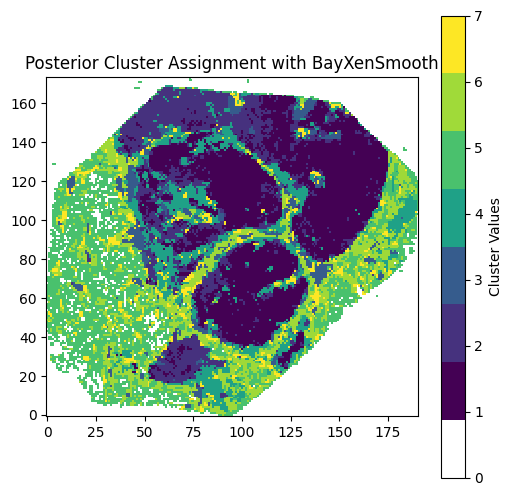

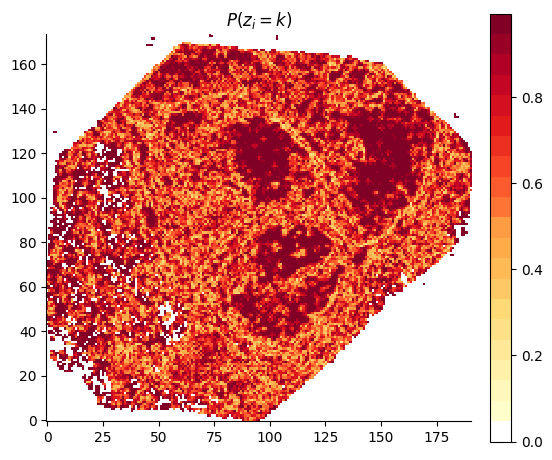

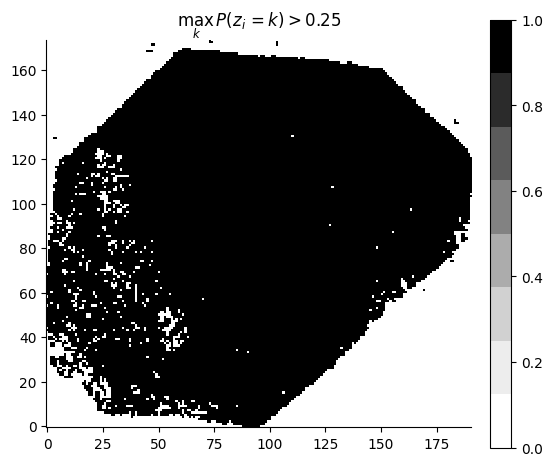

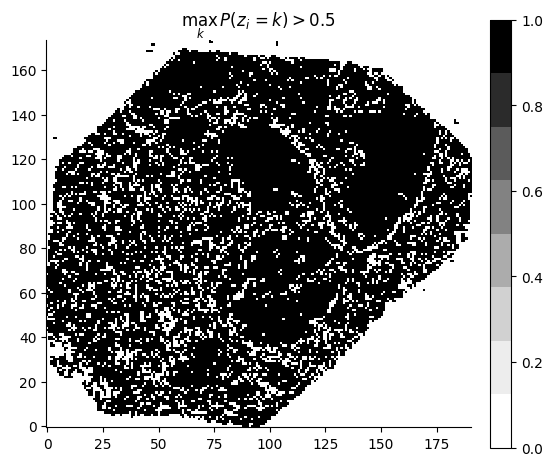

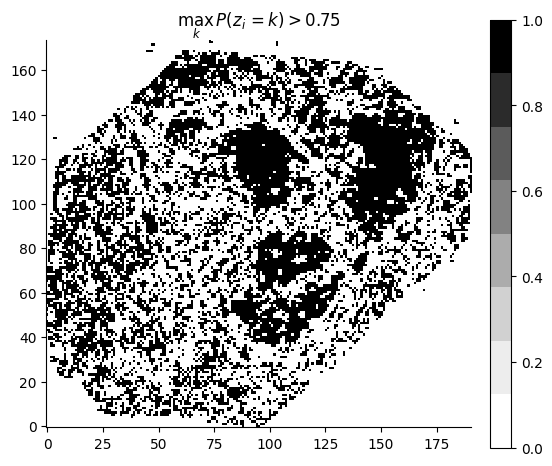

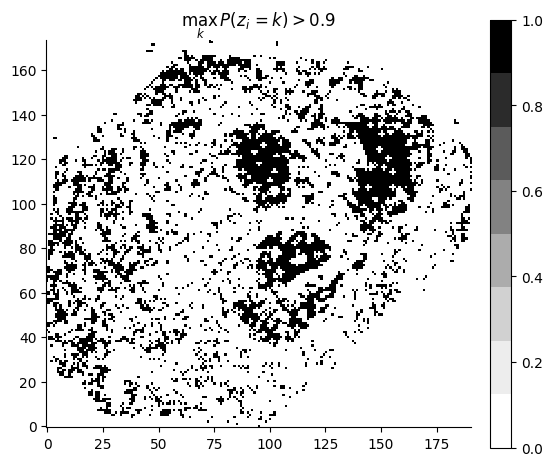

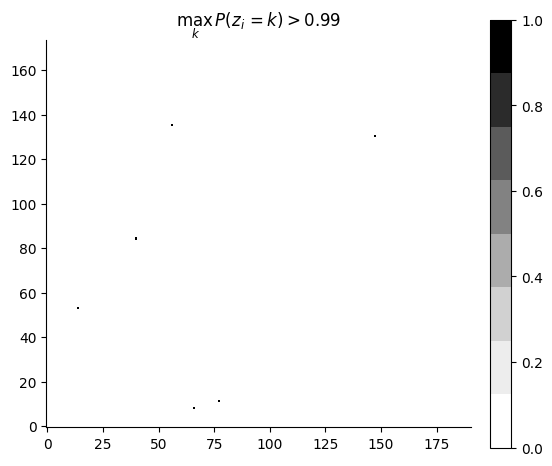

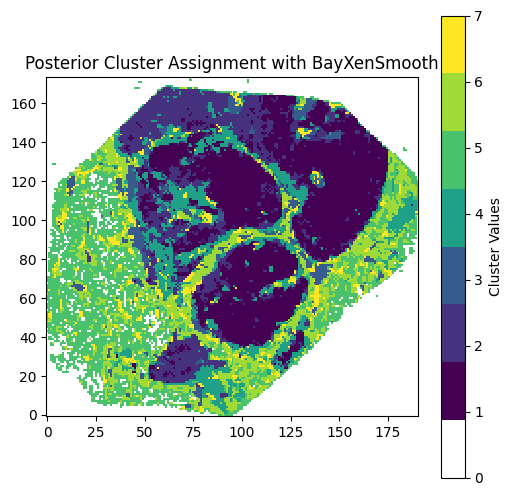

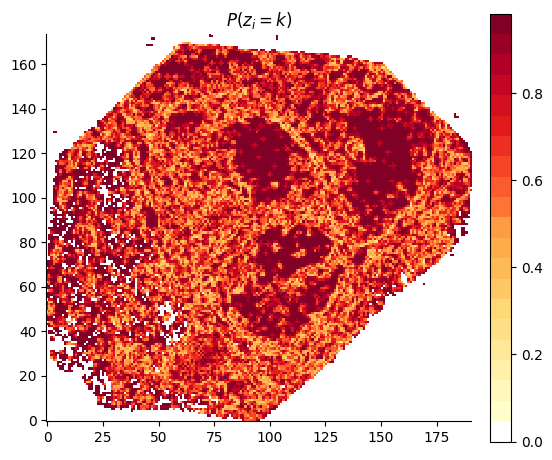

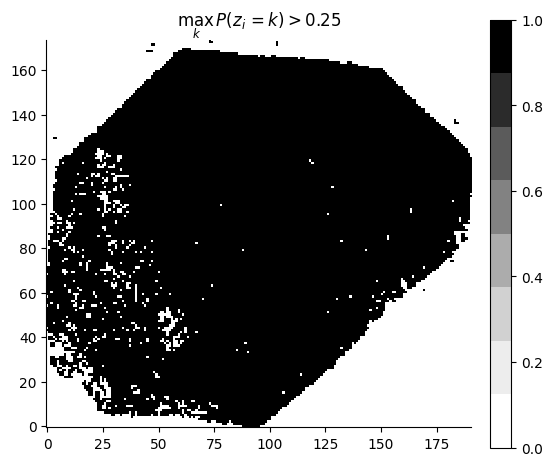

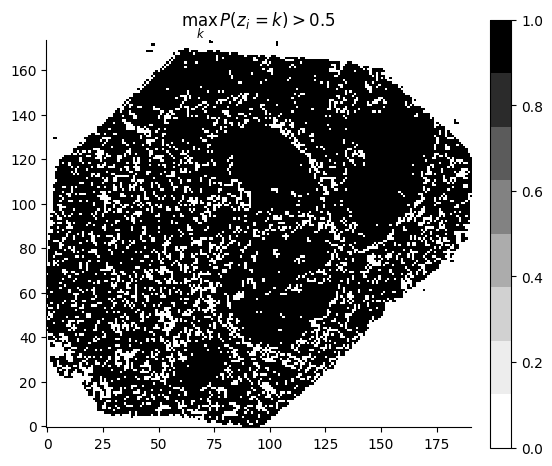

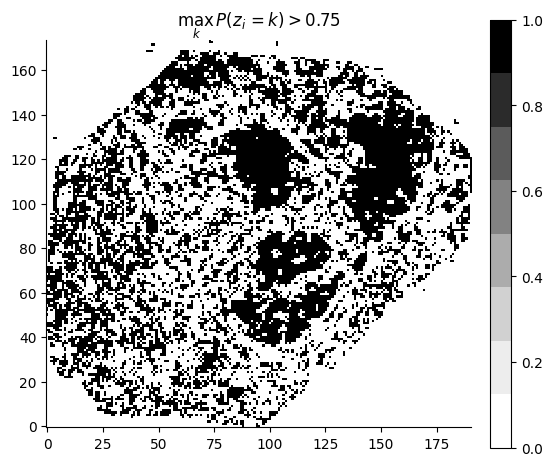

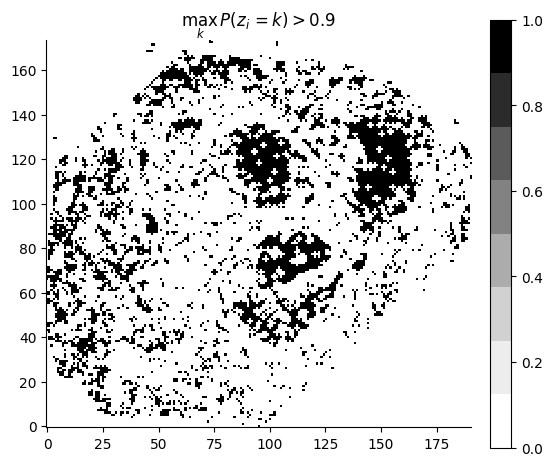

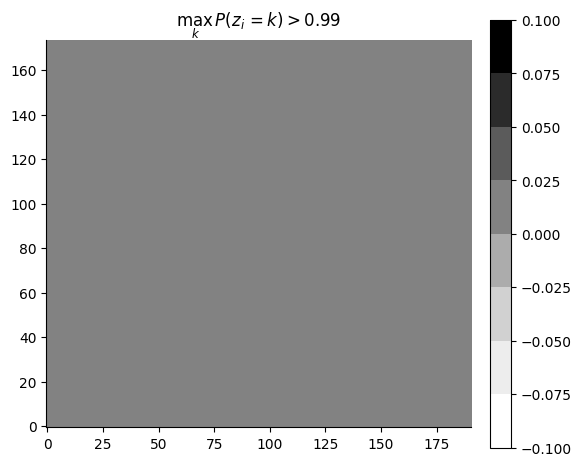

In [20]:
torch.set_default_tensor_type(torch.FloatTensor)

# Grab the learned variational parameters
num_posterior_samples = 100
sample_for_assignment_options = [True, False]

for sample_for_assignment in sample_for_assignment_options:
    cluster_logits_q_mean = pyro.param("cluster_logits_q_mean")
    cluster_logits_q_scale = pyro.param("cluster_logits_q_scale")
    if sample_for_assignment:
        cluster_probs_q = torch.softmax(pyro.sample("cluster_probs", dist.Normal(cluster_logits_q_mean, cluster_logits_q_scale).expand_by([num_posterior_samples]).to_event(1)).mean(dim=0), dim=-1)
        cluster_assignments_q = pyro.sample("cluster_assignments", dist.Categorical(cluster_probs_q).expand_by([num_posterior_samples])).mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_probs_q = torch.softmax(cluster_logits_q_mean, dim=-1)
        cluster_assignments_q = cluster_probs_q.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE
    
    cluster_means_q_mean = pyro.param("cluster_means_q_mean").cpu().detach()
    cluster_scales_q_mean = pyro.param("cluster_scales_q_mean").cpu().detach()
    cluster_probs_q = cluster_probs_q.cpu().detach()
    cluster_assignments_q = cluster_assignments_q.cpu().detach()
    cluster_assignments_prior = cluster_assignments_prior.cpu().detach()

    # Plotting
    if spot_size:

        rows = spatial_locations["row"].astype(int)
        columns = spatial_locations["col"].astype(int)

        num_rows = max(rows) + 1
        num_cols = max(columns) + 1

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

        cluster_grid[rows, columns] = cluster_assignments_q + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)

        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
        colormap = ListedColormap(colormap_colors)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Posterior Cluster Assignment with BayXenSmooth')

        match data_mode:
            case "PCA":
                data_file_path = f"{data_mode}/{num_pcs}"
            case "HVG": 
                data_file_path = f"{data_mode}/{hvg_var_prop}"
            case "ALL":
                data_file_path = f"{data_mode}"
            case _:
                raise ValueError("The data mode specified is not supported.")

        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

        clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"]).to_csv(f"{bayxensmooth_clusters_filepath}/clusters_K={num_clusters}.csv")
        soft_clusters = pd.DataFrame(cluster_probs_q, columns=[f'P(z_i = {i})'  for i in range(1, num_clusters + 1)]).to_csv(f"{bayxensmooth_clusters_filepath}/soft_clusters_K={num_clusters}.csv")

        if not os.path.exists(bayxensmooth_similar_filepath := save_filepath("BayXenSmooth", "prior_v_posterior", sample_for_assignment)):
            os.makedirs(bayxensmooth_similar_filepath)
        with open(f"{bayxensmooth_similar_filepath}/similarity.txt", 'w') as fp:
            prior_similarity = torch.mean((cluster_assignments_prior == cluster_assignments_q).float()).item()
            fp.write(str(prior_similarity))
            print(prior_similarity)

        # grab the WSS distance of cluster labels
        wss = {}
        for label in range(1, num_clusters + 1):
            current_cluster_locations = torch.stack(torch.where((cluster_grid.cpu() == label)), axis=1).to(float)
            wss[f"Cluster {label}"] = (spot_size ** 2) * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
        print("WSS", sum(wss.values()) / 1_000_000)

        if not os.path.exists(bayxensmooth_wss_filepath := save_filepath("BayXenSmooth", "wss", sample_for_assignment)):
            os.makedirs(bayxensmooth_wss_filepath)
        with open(f"{bayxensmooth_wss_filepath}/wss.json", 'w') as fp:
            json.dump(wss, fp)

        cmap = get_cmap('rainbow')

        if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
            labels = np.unique(cluster_assignments_q)  # Define the number of clusters
            gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
            mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

            # Loop through each cluster label
            for label in labels:
                # Find indexes of current cluster
                current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
                
                # Efficiently extract the rows for the current cluster using fancy indexing
                expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
                print(label, expressions.shape)
                
                # Compute mean expressions; the result is still a csr_matrix
                mean_expressions = expressions.mean(axis=0)
                
                # Convert mean_expressions to a dense format and then to a DataFrame
                mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
                
                # Append the result to the mean_expression_by_cluster DataFrame
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
        else:
            # identify marker genes within each cluster
            mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

            for label in range(num_clusters):
                current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0].cpu().numpy())
                expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
                mean_expressions = expressions.mean(axis=0).to_frame().T
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

        if evaluate_markers:
            for i, gene in enumerate(mean_expression_by_cluster.columns):
                # using subplots() to draw vertical lines 
                fig, ax = plt.subplots(figsize=(6, 6)) 
                ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                
                # drawing the markers
                ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                ax.set_ylim(0) 
                
                # formatting and details 
                ax.set_xlabel('Cluster Label') 
                ax.set_ylabel('Mean Expression') 
                ax.set_title(gene) 
                ax.set_xticks(mean_expression_by_cluster[gene].index) 
                if not os.path.exists(bayxensmooth_expression_filepath := save_filepath("BayXenSmooth", "expressions", sample_for_assignment)):
                    os.makedirs(f"{bayxensmooth_expression_filepath}")
                _ = plt.savefig(
                    f"{bayxensmooth_expression_filepath}/GENE={gene}.png"
                )
        
        # confidence mapping
        cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

        cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

        heatmap_bins = 21
        colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
        colormap = ListedColormap(colormap_colors)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_confidences, cmap=colormap, interpolation='nearest', origin='lower')
        # plt.xticks([])  # Remove x-axis tick marks
        # plt.yticks([])  # Remove y-axis tick marks
        plt.gca().spines['top'].set_visible(False)  # Remove top border
        plt.gca().spines['right'].set_visible(False)  # Remove right border
        # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
        # plt.gca().spines['left'].set_visible(False)  # Remove left border
        cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
        plt.title(r'$P(z_i = k)$')


        colors = plt.cm.get_cmap('Greys', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        confidence_proportions = {}
        for uncertainty_value in uncertainty_values:
            confidence_matrix = (cluster_confidences > uncertainty_value).float()
            confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
            plt.figure(figsize=(6, 6))
            plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
            # plt.xticks([])  # Remove x-axis tick marks
            # plt.yticks([])  # Remove y-axis tick marks
            plt.gca().spines['top'].set_visible(False)  # Remove top border
            plt.gca().spines['right'].set_visible(False)  # Remove right border
            # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
            # plt.gca().spines['left'].set_visible(False)  # Remove left border
            cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
            # PLOT ALL UNCERTAINTY VALUESs
            plt.title(r'$\max_k \, P(z_i = k) > $' + f'{uncertainty_value}')
            if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
                os.makedirs(bayxensmooth_uncertainty_filepath)
            _ = plt.savefig(
                f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
            )

    else:

        plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )
    
    gene_data, spatial_locations, original_adata = prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=spot_size, 
        third_dim=False, 
        log_normalize=False, 
        likelihood_mode=data_mode, 
        num_pcs=num_pcs,
        hvg_var_prop=hvg_var_prop,
        min_expressions_per_spot=0
    )

    print("BXS MORAN", sample_for_assignment)
    clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}
    print(morans_i_markers)

    print("INITIAL MORAN", sample_for_assignment)
    clusters = pd.DataFrame(initial_clusters, columns=["initial cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["initial cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}

    print(morans_i_markers)

   P(z_i = 1)  P(z_i = 2)  P(z_i = 3)  P(z_i = 4)  P(z_i = 5)  P(z_i = 6)  \
0    0.000915    0.987425    0.000854    0.000762    0.000917    0.000714   
1    0.000968    0.310339    0.001012    0.000981    0.000947    0.000934   
2    0.001024    0.769795    0.000848    0.000792    0.000831    0.001040   
3    0.236429    0.241208    0.000791    0.000845    0.000977    0.000801   
4    0.000971    0.522430    0.001057    0.000945    0.001080    0.000830   

   P(z_i = 7)  P(z_i = 8)  P(z_i = 9)  P(z_i = 10)  P(z_i = 11)  P(z_i = 12)  \
0    0.000762    0.000799    0.000705     0.000724     0.000764     0.000713   
1    0.000946    0.000938    0.001017     0.000966     0.000932     0.000765   
2    0.000910    0.000879    0.000938     0.000942     0.000934     0.000936   
3    0.000944    0.001066    0.000905     0.000779     0.257056     0.001006   
4    0.000847    0.000934    0.000912     0.000953     0.463405     0.000952   

   P(z_i = 13)  P(z_i = 14)  P(z_i = 15)  P(z_i = 16)  P

Text(0.5, 1.0, '$\\max_k \\,\\, P(z_i = k)$')

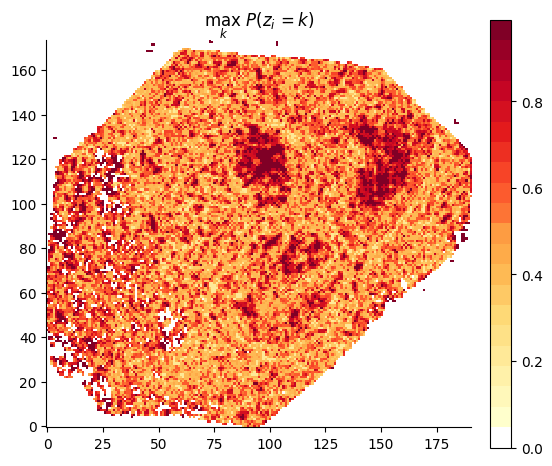

In [21]:
rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.double).cpu()

soft_assignments = pd.read_csv(
    "results/hBreast/BayXenSmooth/clusters/PCA/3/INIT=K-Means/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=1.0/SIGMA_PRIOR=0.25/LOGITS_PRIOR=1.0/LEARN_GLOBAL_VARS=True/soft_clusters_K=17.csv",
    index_col=0
)
print(soft_assignments.head())
cluster_confidences = torch.tensor(soft_assignments.values.max(axis=1)).cpu()

cluster_grid[rows, columns] = cluster_confidences

heatmap_bins = 21
colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
# plt.xticks([])  # Remove x-axis tick marks
# plt.yticks([])  # Remove y-axis tick marks
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
# plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
# plt.gca().spines['left'].set_visible(False)  # Remove left border
cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
plt.title(r'$\max_k \,\, P(z_i = k)$')

TypeError: Invalid shape (23444,) for image data

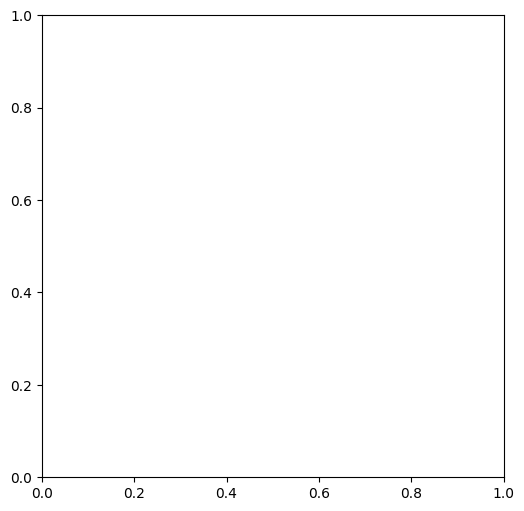

In [22]:
heatmap_bins = 21
colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_confidences, cmap=colormap, interpolation='nearest', origin='lower')
# plt.xticks([])  # Remove x-axis tick marks
# plt.yticks([])  # Remove y-axis tick marks
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
# plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
# plt.gca().spines['left'].set_visible(False)  # Remove left border
cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
plt.title(r'$\max_k P(z_i = k)$')

# confidence_proportions = {}
# for uncertainty_value in uncertainty_values:
#     confidence_matrix = (cluster_confidences > uncertainty_value).float()
#     confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
#     plt.figure(figsize=(6, 6))
#     plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
#     plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
#     # PLOT ALL UNCERTAINTY VALUESs
#     plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
#     if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
#         os.makedirs(bayxensmooth_uncertainty_filepath)
#     _ = plt.savefig(
#         f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
#     )

In [ ]:
plt.figure(figsize=(6, 6))
same_labels = (cluster_grid_PRIOR.cpu() == cluster_grid.cpu()).float() * 2 - 1
same_labels[cluster_grid_PRIOR.cpu() == 0] = 0
colors = plt.cm.get_cmap('bwr', heatmap_bins)
plt.imshow(same_labels, cmap=colors, interpolation='nearest', origin='lower')
plt.colorbar(ticks=[-1,0,1], label='Prior = Posterior', fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
print(f"Proportion of Same Labels: {same_labels.float().mean()}")
_ = plt.title(r'$w_{i, prior} = w_{i, posterior}$')